In [56]:
%pip install pandas
%pip install xlrd
%pip install category-encoders

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 10.0 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas
import xlrd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import BinaryEncoder

# Task 1: Data Loading and Exploration

In [75]:
data = pandas.read_excel("/Users/borisgans/Downloads/titanic3.xls")
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [63]:

print(data.describe())
print(f"\nColumns: {data.columns}")

print(f"\nData types:\n {data.dtypes}")

            pclass     survived          age        sibsp        parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean      2.294882     0.381971    29.881135     0.498854     0.385027   
std       0.837836     0.486055    14.413500     1.041658     0.865560   
min       1.000000     0.000000     0.166700     0.000000     0.000000   
25%       2.000000     0.000000    21.000000     0.000000     0.000000   
50%       3.000000     0.000000    28.000000     0.000000     0.000000   
75%       3.000000     1.000000    39.000000     1.000000     0.000000   
max       3.000000     1.000000    80.000000     8.000000     9.000000   

              fare        body  
count  1308.000000  121.000000  
mean     33.295479  160.809917  
std      51.758668   97.696922  
min       0.000000    1.000000  
25%       7.895800   72.000000  
50%      14.454200  155.000000  
75%      31.275000  256.000000  
max     512.329200  328.000000  

Columns: Index(['pclass', 'survived

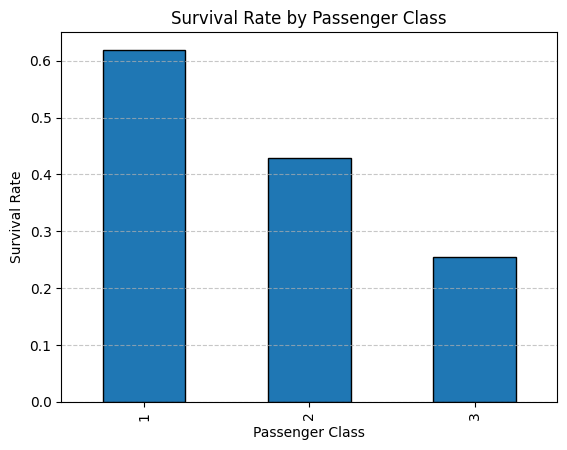

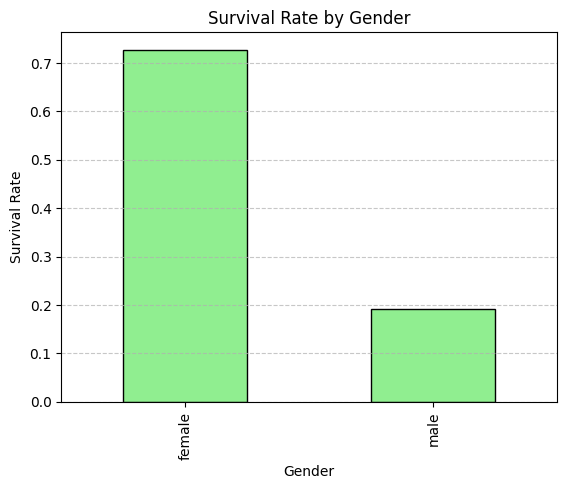

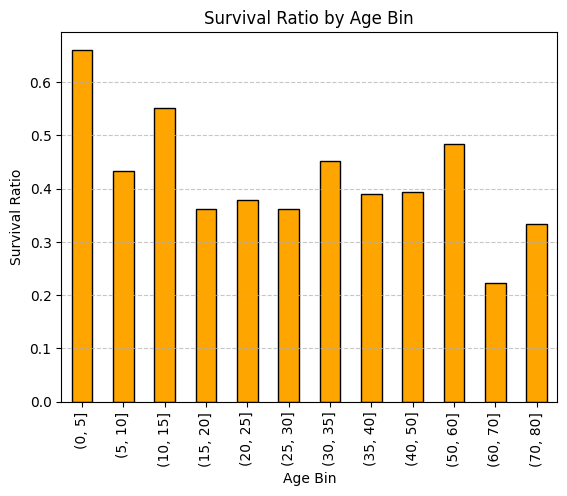

0                          St Louis, MO
1       Montreal, PQ / Chesterville, ON
2       Montreal, PQ / Chesterville, ON
3       Montreal, PQ / Chesterville, ON
4       Montreal, PQ / Chesterville, ON
                     ...               
1304                                NaN
1305                                NaN
1306                                NaN
1307                                NaN
1308                                NaN
Name: home.dest, Length: 1309, dtype: object


In [76]:
#Survival rate vs passenger class
survival_by_class = data.groupby('pclass')['survived'].mean()
survival_by_class.plot(kind='bar', edgecolor='black')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Survival rate vs gender
survival_by_sex = data.groupby('sex')['survived'].mean()
survival_by_sex.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Survival rate vs age
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
data['age_bin'] = pandas.cut(data['age'], bins=age_bins)

survival_by_age_bin = data.groupby('age_bin')['survived'].mean()
survival_by_age_bin.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Survival Ratio by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Survival Ratio')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"{data['home.dest']}")


# Task 2: Managing Missing Values

In [77]:
data.drop(columns=['age_bin'], inplace=True)
pre_split_data = data.copy()
pre_split_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Data.info() shows the count of non-null entries per column. Here we can see that:
>- Age is missing 263 values
>- Fare is missing 1 value
>- Cabin is missing 1014 values
>- Embarked is missing two values
>- Boat is missing 823 values
>- Body is missing 1188 values
>- Home Destination is missing 564 values

At first, I imputed missing values before splitting my dataset into train, test, and validation sets. This is a very common and obvious way to encounter data leakage, because the values I'd impute (through staticial methods) would be the same in all 3 sets. So any patterns / relationships my model might establish from the training set will inherintly also be present in the test and validation sets. This means that some of the data in these two sets won't actually be new to the model and the performance statstics will be overly optimistic.

Instead, I can only use non-statical methods to manage missing values before splitting the dataset, meaning deleting columns and assinging constants to unknown values. I will only do this to categorical variables, as the value of 'Unknown' should have some sort of meaning and I've also found that its best practice because I may forget to impute these values later.
>- I will delete the cabin column, as it only has 295 values and in my opinion has little predictive power.
>- I will delete the body column, as it also has very few values and in my opinion it has little predicitve power.
>- I will fill in all missing values in the home.dest and embarked columns with 'Unknown'
>- For now, I will fill in all missing values in the boat column with 'Unknown', but I'm unsure if it has any predictive power so I may circle back and delete it.

In [78]:
# Deleting cabin and body columns
pre_split_data.drop(columns=['cabin', 'body'], inplace=True)

# Assinging 'unknown' to missing values in the home.dest, embarked, and boat columns
pre_split_data.fillna({'home.dest': 'unknown', 'embarked': 'unknown', 'boat': 'unknown'}, inplace=True)

pre_split_data.info() #confirming its right


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   embarked   1309 non-null   object 
 10  boat       1309 non-null   object 
 11  home.dest  1309 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


Before I split the dataset and impute missing values, I will encode all applicable categorical variables using One-hot encoding. This only includes the 'Sex' and 'Embarked' columns. Pclass is already encoded in an ordered manner (1 - 3) so I don't need to worry about it, otherwise I would use Ordinal encoding for this.

In [79]:
pre_split_data = pandas.get_dummies(pre_split_data, columns=['sex'], drop_first=True)
pre_split_data = pandas.get_dummies(pre_split_data, columns=['embarked'], drop_first=True)
pre_split_data.head(10)

,pclass,survived,name,age,sibsp,parch,ticket,fare,boat,home.dest,sex_male,embarked_Q,embarked_S,embarked_unknown
0,1,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,211.3375,2,"St Louis, MO",False,False,True,False
1,1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,151.5500,11,"Montreal, PQ / Chesterville, ON",True,False,True,False
2,1,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",False,False,True,False
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",True,False,True,False
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,151.5500,unknown,"Montreal, PQ / Chesterville, ON",False,False,True,False
5,1,1,"Anderson, Mr. Harry",48.0000,0,0,19952,26.5500,3,"New York, NY",True,False,True,False
6,1,1,"Andrews, Miss. Kornelia Theodosia",63.0000,1,0,13502,77.9583,10,"Hudson, NY",False,False,True,False
7,1,0,"Andrews, Mr. Thomas Jr",39.0000,0,0,112050,0.0000,unknown,"Belfast, NI",True,False,True,False
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",53.0000,2,0,11769,51.4792,D,"Bayside, Queens, NY",False,False,True,False
9,1,0,"Artagaveytia, Mr. Ramon",71.0000,0,0,PC 17609,49.5042,unknown,"Montevideo, Uruguay",True,False,False,False


# Task 5: Splitting the dataset

First, I will just split the dataset into 'traing' and 'others' to ensure the training set is large enough. Then I split the 'others' datset into 'test' and 'validation', ensuring both are the same size.

By using stratification, I ensure that each set has the same proportion of 'survived' values as the original dataset.

Training set: 916 samples
Validation set: 196 samples
Test set: 197 samples


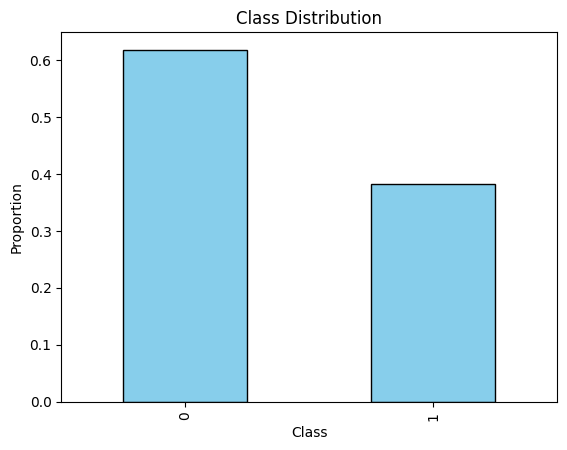

In [80]:
target_column = pre_split_data['survived']
other_columns = pre_split_data.drop(columns='survived')

# Both test_size and random_state are essentially arbitrary. 
    # 30/70 split between train and others is on the higher end (based on my limited knowledge), but it just ensures that the model has ample data to learn from
    # Random state of 42 is essentially meaningless, but I think it just acts as the seed for the randomization. This should stay the same for all splits (when splitting others)
main_train, main_other, target_train, target_other = train_test_split(
    other_columns, target_column, test_size=0.3, random_state=42, stratify=target_column
)

main_validation, main_test, target_validation, target_test = train_test_split(
    main_other, target_other, test_size=0.5, random_state=42, stratify=target_other
)
# By stratifying target value (survived) in both splits, the main and other sets have the same proportion of survived passengers 
# and the validation and test sets have the same proportion of survived passengers

print(f"Training set: {len(main_train)} samples")
print(f"Validation set: {len(main_validation)} samples")
print(f"Test set: {len(main_test)} samples")

target_train.value_counts(normalize=True).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

As we can see in the above graph, there are way more people that died than survived in our test set. This is a problem when training a model, as it'll lead to predictions biased towards not surviving. If the model predicted that everyone didn't survive it will still have an accuracy of ~60%.

To address this, we need to fix this class imbalance through resampling: either oversampling (more survivors) or undersampling (less deceased). First, however, we should impute the missing values and finish encoding the categorical variables. Also, we will need to scale our features first.

Since we used stratification when splitting, this imbalance is also present in our test and validation sets. However these should remain unchanged, as they should represent real-world data (not 50-50)

# Finishing Task 2: Managing Missing Values


To summarize, our dataset is still missing numerical values in the age column and in the fare column. Since we deleted the cabin and body columns, these missing values are no longer a concern. 

Embarked, home destination and boat also have missing values, but I already assinged a value of 'Unknown' to these so now I just need to encode these columns.

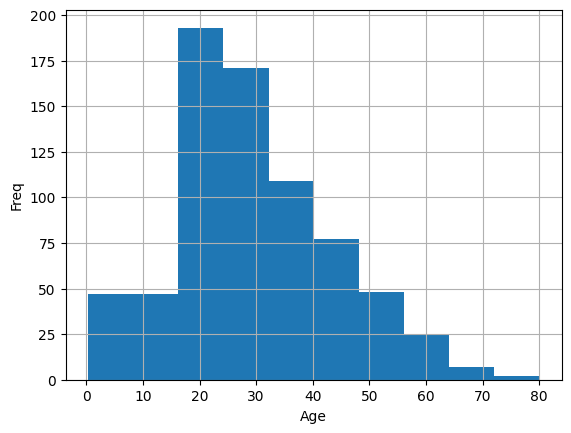

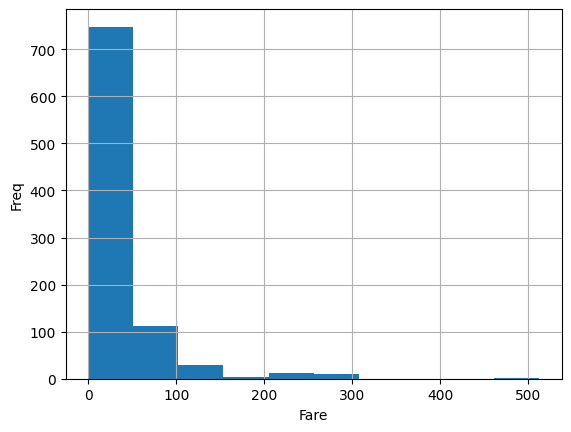

In [81]:
# main_train.info()
main_train['age'].hist()
plt.xlabel('Age')
plt.ylabel('Freq')
plt.show()

main_train['fare'].hist()
plt.xlabel('Fare')
plt.ylabel('Freq')
plt.show()


In [82]:
# As you can see in the above plots, both the age and fare columns are heavily skewed. 
# This means we should use the median, rather than the mean, as the impute value.

train_age_median = main_train['age'].median()
train_fare_median = main_train['fare'].median()

main_train['age'].fillna(train_age_median, inplace=True)
main_validation['age'].fillna(train_age_median, inplace=True)
main_test['age'].fillna(train_age_median, inplace=True)

main_train['fare'].fillna(train_fare_median, inplace=True)
main_validation['fare'].fillna(train_fare_median, inplace=True)
main_test['fare'].fillna(train_fare_median, inplace=True)

main_train.info()
main_validation.info()
main_test.info()
# Confirming all vals are filled in


<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 306 to 2
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pclass            916 non-null    int64  
 1   name              916 non-null    object 
 2   age               916 non-null    float64
 3   sibsp             916 non-null    int64  
 4   parch             916 non-null    int64  
 5   ticket            916 non-null    object 
 6   fare              916 non-null    float64
 7   boat              916 non-null    object 
 8   home.dest         916 non-null    object 
 9   sex_male          916 non-null    bool   
 10  embarked_Q        916 non-null    bool   
 11  embarked_S        916 non-null    bool   
 12  embarked_unknown  916 non-null    bool   
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 75.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 1129 to 1121
Data columns (total 13 columns):
 #   Column        

# Finishing Task 3: Encoding Categorical Variables

The categorical variables to encode are the following:
>- Name
>- Ticket
>- Home destination
>- Boat

For name I'll use binary encoding, because it is suited for high-cardinality features by reducing its dimensionality.

For ticket I'll also use binary encoding. Tickets are nearly unique, meaning this column also has high-cardinality.

For home destination I'll use count encoding, because ...



In [83]:
print(f"{main_train['home.dest'].nunique()}")

encoder= BinaryEncoder(cols=['name', 'ticket'])
main_train = encoder.fit_transform(main_train)
main_validation = encoder.transform(main_validation)
main_test = encoder.transform(main_test)

297
